In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Sat Jan 13 22:22:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    15W / 230W |  17558MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 35%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-4/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


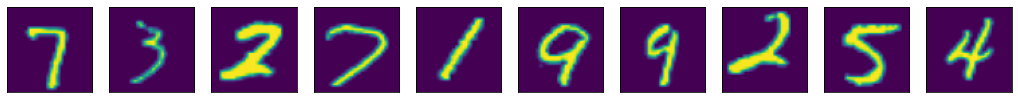

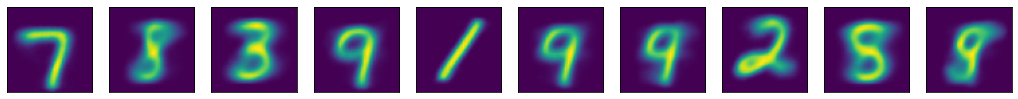

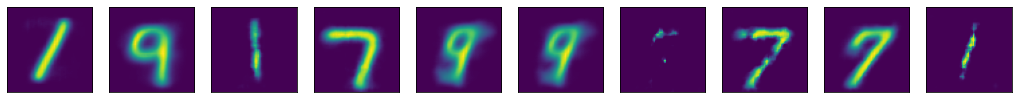

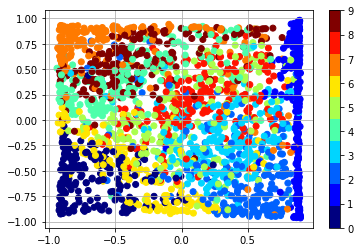

147001
lse_loss 0.574644148349762
recon_loss 0.1524117887020111
147002
lse_loss 0.48903048038482666
recon_loss 0.1493363231420517
147003
lse_loss 0.6253004670143127
recon_loss 0.14881503582000732
147004
lse_loss 0.6044318079948425
recon_loss 0.15946099162101746
147005
lse_loss 0.5368368029594421
recon_loss 0.14695590734481812
147006
lse_loss 0.5008431673049927
recon_loss 0.1576065868139267
147007
lse_loss 0.5821335911750793
recon_loss 0.15798170864582062
147008
lse_loss 0.5587282180786133
recon_loss 0.15346255898475647
147009
lse_loss 0.42504122853279114
recon_loss 0.14828425645828247
147010
lse_loss 0.5522021651268005
recon_loss 0.15665285289287567
147011
lse_loss 0.6125222444534302
recon_loss 0.13892388343811035
147012
lse_loss 0.47728559374809265
recon_loss 0.14339706301689148
147013
lse_loss 0.4949348270893097
recon_loss 0.14946387708187103
147014
lse_loss 0.439249724149704
recon_loss 0.1466549038887024
147015
lse_loss 0.5709086060523987
recon_loss 0.15591943264007568
147016
lse_lo

lse_loss 0.5264981985092163
recon_loss 0.15233545005321503
147130
lse_loss 0.4506474733352661
recon_loss 0.15356019139289856
147131
lse_loss 0.4691926836967468
recon_loss 0.1517387479543686
147132
lse_loss 0.5042506456375122
recon_loss 0.14701665937900543
147133
lse_loss 0.7006873488426208
recon_loss 0.1485682874917984
147134
lse_loss 0.45846259593963623
recon_loss 0.15136085450649261
147135
lse_loss 0.6452142596244812
recon_loss 0.1475849747657776
147136
lse_loss 0.42371615767478943
recon_loss 0.14786182343959808
147137
lse_loss 0.5816825032234192
recon_loss 0.15678265690803528
147138
lse_loss 0.48438072204589844
recon_loss 0.1486050933599472
147139
lse_loss 0.6515523791313171
recon_loss 0.1489565223455429
147140
lse_loss 0.5189368724822998
recon_loss 0.14204458892345428
147141
lse_loss 0.487599641084671
recon_loss 0.15626558661460876
147142
lse_loss 0.4720664918422699
recon_loss 0.15363168716430664
147143
lse_loss 0.5077608227729797
recon_loss 0.1492399275302887
147144
lse_loss 0.482

147254
lse_loss 0.4718744158744812
recon_loss 0.1446925699710846
147255
lse_loss 0.5884748697280884
recon_loss 0.1565747857093811
147256
lse_loss 0.5554777383804321
recon_loss 0.14456132054328918
147257
lse_loss 0.5445099472999573
recon_loss 0.16278290748596191
147258
lse_loss 0.4212077856063843
recon_loss 0.15395735204219818
147259
lse_loss 0.43403616547584534
recon_loss 0.13754650950431824
147260
lse_loss 0.6270084381103516
recon_loss 0.1496749371290207
147261
lse_loss 0.4019842743873596
recon_loss 0.15135233104228973
147262
lse_loss 0.5262208580970764
recon_loss 0.14450527727603912
147263
lse_loss 0.6286317706108093
recon_loss 0.15013530850410461
147264
lse_loss 0.3882282078266144
recon_loss 0.1545078605413437
147265
lse_loss 0.9326738715171814
recon_loss 0.15860682725906372
147266
lse_loss 0.4648251533508301
recon_loss 0.13852781057357788
147267
lse_loss 0.5747814178466797
recon_loss 0.15370282530784607
147268
lse_loss 0.5688496828079224
recon_loss 0.14427828788757324
147269
lse_lo

recon_loss 0.15446940064430237
147381
lse_loss 0.6043699979782104
recon_loss 0.14592880010604858
147382
lse_loss 0.5183244943618774
recon_loss 0.15382468700408936
147383
lse_loss 0.46172866225242615
recon_loss 0.15133212506771088
147384
lse_loss 0.5741133093833923
recon_loss 0.1422402411699295
147385
lse_loss 0.569404125213623
recon_loss 0.1438112109899521
147386
lse_loss 0.7569607496261597
recon_loss 0.15895724296569824
147387
lse_loss 0.4404607117176056
recon_loss 0.13850007951259613
147388
lse_loss 0.4041330814361572
recon_loss 0.14740745723247528
147389
lse_loss 0.46698030829429626
recon_loss 0.15418677031993866
147390
lse_loss 0.5660879015922546
recon_loss 0.14302289485931396
147391
lse_loss 0.5682108402252197
recon_loss 0.1463032364845276
147392
lse_loss 0.6225380897521973
recon_loss 0.16758882999420166
147393
lse_loss 0.5318388342857361
recon_loss 0.15093526244163513
147394
lse_loss 0.5128536820411682
recon_loss 0.1446210741996765
147395
lse_loss 0.4691513776779175
recon_loss 0.

147508
lse_loss 0.46212032437324524
recon_loss 0.14695337414741516
147509
lse_loss 0.5103918313980103
recon_loss 0.15111695230007172
147510
lse_loss 0.6250354647636414
recon_loss 0.163131982088089
147511
lse_loss 0.5860397219657898
recon_loss 0.13720449805259705
147512
lse_loss 0.5138351321220398
recon_loss 0.1402806043624878
147513
lse_loss 0.5389219522476196
recon_loss 0.13641230762004852
147514
lse_loss 0.5215955972671509
recon_loss 0.14655253291130066
147515
lse_loss 0.5618285536766052
recon_loss 0.14515423774719238
147516
lse_loss 0.4112449288368225
recon_loss 0.15011225640773773
147517
lse_loss 0.4629122018814087
recon_loss 0.14933925867080688
147518
lse_loss 0.48292776942253113
recon_loss 0.1419645994901657
147519
lse_loss 0.39498308300971985
recon_loss 0.1572703719139099
147520
lse_loss 0.6344690322875977
recon_loss 0.14753971993923187
147521
lse_loss 0.40788066387176514
recon_loss 0.14773160219192505
147522
lse_loss 0.4284384846687317
recon_loss 0.14221912622451782
147523
lse_

147634
lse_loss 0.5229701399803162
recon_loss 0.14187297224998474
147635
lse_loss 0.5231117606163025
recon_loss 0.14018681645393372
147636
lse_loss 0.5943456888198853
recon_loss 0.14346450567245483
147637
lse_loss 0.540393590927124
recon_loss 0.15712721645832062
147638
lse_loss 0.6660096645355225
recon_loss 0.14782555401325226
147639
lse_loss 0.5134955048561096
recon_loss 0.1504870057106018
147640
lse_loss 0.5617011785507202
recon_loss 0.15222357213497162
147641
lse_loss 0.6178722381591797
recon_loss 0.14251922070980072
147642
lse_loss 0.5400130748748779
recon_loss 0.13541816174983978
147643
lse_loss 0.5102547407150269
recon_loss 0.13831697404384613
147644
lse_loss 0.526839017868042
recon_loss 0.16345000267028809
147645
lse_loss 0.4998200237751007
recon_loss 0.14927709102630615
147646
lse_loss 0.5702018141746521
recon_loss 0.14531929790973663
147647
lse_loss 0.4219048023223877
recon_loss 0.13383899629116058
147648
lse_loss 0.5584215521812439
recon_loss 0.15047235786914825
147649
lse_lo

lse_loss 0.5825100541114807
recon_loss 0.14806543290615082
147760
lse_loss 0.6261979937553406
recon_loss 0.14078062772750854
147761
lse_loss 0.6287760138511658
recon_loss 0.15035897493362427
147762
lse_loss 0.4981556534767151
recon_loss 0.14280012249946594
147763
lse_loss 0.4273838698863983
recon_loss 0.14490574598312378
147764
lse_loss 0.5596269965171814
recon_loss 0.1392768919467926
147765
lse_loss 0.5386067032814026
recon_loss 0.1491638720035553
147766
lse_loss 0.495690256357193
recon_loss 0.14639568328857422
147767
lse_loss 0.6123558878898621
recon_loss 0.16266290843486786
147768
lse_loss 0.5619421601295471
recon_loss 0.14253461360931396
147769
lse_loss 0.5024802684783936
recon_loss 0.14478564262390137
147770
lse_loss 0.5068603157997131
recon_loss 0.1486697643995285
147771
lse_loss 0.5293276906013489
recon_loss 0.15235254168510437
147772
lse_loss 0.492428719997406
recon_loss 0.15652970969676971
147773
lse_loss 0.4798632860183716
recon_loss 0.1485268920660019
147774
lse_loss 0.47665

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=0.067)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        